# Hierarchical, Explainable Cyberbullying Classifier

**Dataset:** Cyberbullying texts (tweets/comments).  
**Goal:** Two-stage prediction—(1) Bullying vs Not; (2) If bullying, the **type**: `age`, `ethnicity`, `gender`, `religion`, `other`.  
**Benefits:** Mirrors real moderation pipelines; often improves precision on “not_cyberbullying”.

**Notebook outline**
1. Brief dataset overview
2. Data audit & preprocessing (de-dup, URL/@ normalization, emoji handling, hashtag splitting, text fixes)
3. Train a shared-encoder model with two heads (binary + 5-way), mask the 5-way loss when “not”
4. Evaluate: Binary F1, Macro-F1 over 6 classes, confusion matrix, per-class F1, PR curves
5. Save model + tokenizer + config + label map to `artifacts/`

*Hardware:* RTX 4070 Laptop GPU. PyTorch with CUDA 12.8 wheels.


In [1]:
import os, json, re, math, random, gc, warnings
from collections import Counter, defaultdict
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, precision_recall_fscore_support,
                             roc_auc_score, average_precision_score)
from sklearn.preprocessing import LabelEncoder

from transformers import (AutoTokenizer, AutoModel, get_linear_schedule_with_warmup)
from tqdm.auto import tqdm
import ftfy, emoji, regex as re2
from wordsegment import load as ws_load, segment as ws_segment

In [2]:
# Repro
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

In [3]:
# Paths
DATA_RAW = "../data/raw/cyberbullying_raw.csv"
DATA_CLEAN = "../data/interim/cleaned.csv"
ARTIFACTS_DIR = "../artifacts"
os.makedirs(os.path.dirname(DATA_CLEAN), exist_ok=True)
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

In [4]:
# Model/config
ENCODER = "roberta-base"      # switch later to "vinai/bertweet-base" if you like
MAX_LEN = 96
BATCH_SIZE = 16               # fits 8GB VRAM with fp16
EPOCHS = 4
LR_ENC = 2e-5
LR_HEAD = 1e-4
WARMUP_RATIO = 0.1
LAMBDA = 0.5                  # loss mix: lambda*binary + (1-lambda)*5-way
BIN_THRESHOLD = 0.5

In [5]:
# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Device: cuda
GPU: NVIDIA GeForce RTX 4070 Laptop GPU


In [6]:
# Tokenizers parallelism warning off
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [7]:
# wordsegment init
ws_load()

In [8]:
# %% [code]
def try_read_csv(path):
    try:
        return pd.read_csv(path)
    except UnicodeDecodeError:
        return pd.read_csv(path, encoding="latin-1")

df_raw = try_read_csv(DATA_RAW)
print("Raw shape:", df_raw.shape)
df_raw.head(2)

Raw shape: (47692, 2)


,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying


In [9]:
# %% [code]
def guess_columns(df):
    # candidate text columns: object dtype with median length > ~8
    text_cands = []
    for c in df.columns:
        if df[c].dtype == object:
            sample = df[c].dropna().astype(str).head(500).tolist()
            if not sample: 
                continue
            med_len = np.median([len(s) for s in sample])
            if med_len >= 8:
                text_cands.append(c)
    # candidate label columns: low unique cardinality and not free text
    label_cands = [c for c in df.columns if df[c].nunique()<=20 and df[c].dtype!=float]

    text_col = text_cands[0] if text_cands else df.columns[0]
    # prefer a label column that looks like class names
    pref = ["label","labels","class","cyberbullying_type","category","target"]
    label_col = None
    for p in pref:
        if p in df.columns:
            label_col = p; break
    if label_col is None:
        # fallback to smallest unique
        label_col = min(label_cands, key=lambda c: df[c].nunique()) if label_cands else df.columns[-1]
    return text_col, label_col

TEXT_COL, LABEL_COL = guess_columns(df_raw)
TEXT_COL, LABEL_COL

('tweet_text', 'cyberbullying_type')

## Data audit (duplicates, nulls, lengths, class balance)

text     0
label    0
dtype: int64

Class distribution:
 label
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64


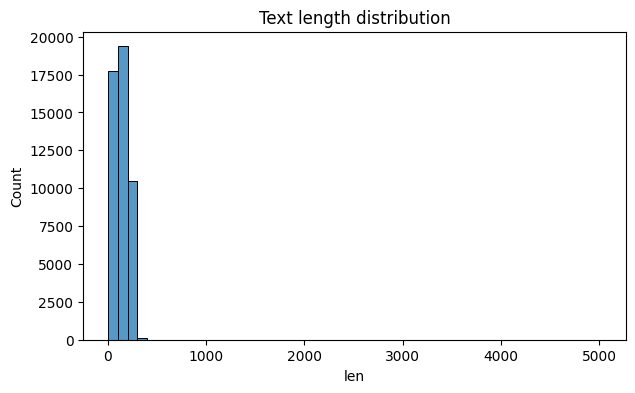

Exact duplicate rate: 3.512%


,text,label
40362,@Goree_JuhssGuns hahaha he ain't even worth my...,ethnicity
15019,RT @hsaymssik: Sucks to have the smile wiped o...,gender
46321,"Just a reminder, it's absolutely disgusting to...",ethnicity
23927,RT @BuzzFeedUK: When you accidentally open you...,other_cyberbullying
1640,Loving the look of the fritters! #mkr,not_cyberbullying


In [10]:
# %% [code]
df = df_raw[[TEXT_COL, LABEL_COL]].rename(columns={TEXT_COL:"text", LABEL_COL:"label"})
df["text"] = df["text"].astype(str)

# Basic stats
print(df.isna().sum())
print("\nClass distribution:\n", df["label"].value_counts(dropna=False))

# Text length
df["len"] = df["text"].str.len()
fig, ax = plt.subplots(figsize=(7,4))
sns.histplot(df["len"], bins=50, ax=ax)
ax.set_title("Text length distribution")
plt.show()

# Duplicates
dup_rate = df.duplicated(subset=["text"]).mean()
print(f"Exact duplicate rate: {dup_rate:.3%}")

# Quick samples
df.sample(5, random_state=SEED)[["text","label"]]


## Normalization & cleaning helpers

In [11]:
# %% [code]
URL_RE   = re.compile(r"(https?://\S+|www\.\S+)")
USER_RE  = re.compile(r"@\w+")
HASH_RE  = re.compile(r"#(\w+)")
SPACE_RE = re.compile(r"\s+")

def split_hashtag(tag):
    # tag without '#', lowercased, segmented by wordsegment
    if not tag: return ""
    words = ws_segment(tag)
    return " ".join(words)

def normalize_text(s: str) -> str:
    s = ftfy.fix_text(str(s))
    s = URL_RE.sub("<url>", s)
    s = USER_RE.sub("<user>", s)
    # split hashtags into tokens
    def _sub(m):
        return " " + split_hashtag(m.group(1)) + " "
    s = HASH_RE.sub(_sub, s)
    # demojize or keep emojis (BERTweet likes emojis, RoBERTa is ok either way)
    # Here we map emojis to text names for interpretability:
    s = emoji.demojize(s, delimiters=(" ", " "))
    s = s.lower().strip()
    s = SPACE_RE.sub(" ", s)
    return s

# De-duplication in two phases: exact and near (after rough normalization)
df["text_norm"] = df["text"].apply(lambda x: normalize_text(x))
print("Before de-dup:", df.shape)
df = df.drop_duplicates(subset=["text_norm"]).reset_index(drop=True)
print("After de-dup:", df.shape)

# Drop very short after normalization (noise)
df = df[df["text_norm"].str.len() >= 3].reset_index(drop=True)
df[["text","text_norm","label"]].head(5)


Before de-dup: (47692, 4)
After de-dup: (45439, 4)


,text,text_norm,label
0,"In other words #katandandre, your food was cra...","in other words kat and andre , your food was c...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,why is aussie tv so white? mkr the block ima c...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,<user> a classy whore? or more red velvet cupc...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...","<user> meh. :p thanks for the heads up, but no...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,<user> this is an isis account pretending to b...,not_cyberbullying


## Label mapping and save a cleaned CSV

In [12]:
# %% [code]
# Standardize labels into: not_cyberbullying, age, ethnicity, gender, religion, other
canon_map = {
    "not_cyberbullying": "not_cyberbullying",
    "not": "not_cyberbullying",
    "none": "not_cyberbullying",
    "age": "age",
    "ethnicity": "ethnicity",
    "gender": "gender",
    "religion": "religion",
    "other_cyberbullying": "other",
    "other": "other",
}
df["label_str"] = df["label"].astype(str).str.strip().str.lower().map(canon_map).fillna(df["label"].astype(str).str.lower())
allowed = {"not_cyberbullying","age","ethnicity","gender","religion","other"}
df = df[df["label_str"].isin(allowed)].reset_index(drop=True)

label2id = {lbl:i for i,lbl in enumerate(["not_cyberbullying","age","ethnicity","gender","religion","other"])}
id2label = {v:k for k,v in label2id.items()}
df["label_id"] = df["label_str"].map(label2id)

# y_binary: 0 for not, 1 for bullying
df["y_bin"] = (df["label_str"] != "not_cyberbullying").astype(int)

print(df["label_str"].value_counts())
df[["text_norm","label_str","label_id","y_bin"]].head()

# Save cleaned
df_clean = df[["text_norm","label_str","label_id","y_bin"]].rename(columns={"text_norm":"text"})
df_clean.to_csv(DATA_CLEAN, index=False)
print("Saved:", DATA_CLEAN)


label_str
religion             7979
age                  7959
ethnicity            7921
not_cyberbullying    7816
gender               7720
other                6040
Name: count, dtype: int64
Saved: ../data/interim/cleaned.csv


## Stratified split

In [13]:
# %% [code]
train_df, temp_df = train_test_split(df_clean, test_size=0.2, random_state=SEED, stratify=df_clean["label_id"])
val_df, test_df   = train_test_split(temp_df, test_size=0.5, random_state=SEED, stratify=temp_df["label_id"])

for name, d in [("train",train_df),("val",val_df),("test",test_df)]:
    print(name, d.shape, "class balance:", dict(Counter(d["label_str"])))


train (36348, 4) class balance: {'religion': 6383, 'other': 4832, 'age': 6367, 'gender': 6176, 'ethnicity': 6337, 'not_cyberbullying': 6253}
val (4543, 4) class balance: {'gender': 772, 'not_cyberbullying': 781, 'religion': 798, 'age': 796, 'ethnicity': 792, 'other': 604}
test (4544, 4) class balance: {'ethnicity': 792, 'age': 796, 'not_cyberbullying': 782, 'gender': 772, 'other': 604, 'religion': 798}


## Tokenizer & Dataset

In [14]:
# %% [code]
tokenizer = AutoTokenizer.from_pretrained(ENCODER, use_fast=True)

class CyberDS(Dataset):
    def __init__(self, frame, tokenizer, max_len=96):
        self.f = frame.reset_index(drop=True)
        self.tok = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.f)
    def __getitem__(self, idx):
        row = self.f.iloc[idx]
        enc = self.tok(row["text"], truncation=True, padding="max_length",
                       max_length=self.max_len, return_tensors="pt")
        item = {k: v.squeeze(0) for k,v in enc.items()}
        item["y_bin"] = torch.tensor(row["y_bin"], dtype=torch.float32)
        # map 6-class into [0..5] where 0==not, 1..5 == bullying types
        item["y_multi"] = torch.tensor(row["label_id"] - 0, dtype=torch.long)  # already 0..5
        return item

train_ds = CyberDS(train_df, tokenizer, MAX_LEN)
val_ds   = CyberDS(val_df, tokenizer, MAX_LEN)
test_ds  = CyberDS(test_df, tokenizer, MAX_LEN)

# Weighted sampler to reduce class imbalance effects (on 6-way labels)
counts = train_df["label_id"].value_counts().to_dict()
weights = train_df["label_id"].map(lambda x: 1.0 / counts[x]).values


# --- SAFE DATALOADERS FOR WINDOWS/JUPYTER ---
NUM_WORKERS = 0             # <- key fix
PERSISTENT = False

# Option A (quickest debug): remove sampler; just shuffle
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                      num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=PERSISTENT)

# Keep val/test simple
val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=PERSISTENT)
test_dl  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=PERSISTENT)



## Model (shared encoder, two heads)

In [15]:
# %% [code]
class HierXAI(nn.Module):
    def __init__(self, encoder_name="roberta-base", hidden_dropout=0.1):
        super().__init__()
        self.enc = AutoModel.from_pretrained(encoder_name)
        h = self.enc.config.hidden_size
        self.dropout = nn.Dropout(hidden_dropout)
        self.bin_head = nn.Linear(h, 1)      # bully vs not
        self.multi_head = nn.Linear(h, 5)    # 5 types: age, ethnicity, gender, religion, other

    def forward(self, input_ids, attention_mask):
        out = self.enc(input_ids=input_ids, attention_mask=attention_mask)
        cls = out.last_hidden_state[:, 0, :]       # CLS / <s>
        z = self.dropout(cls)
        logit_bin = self.bin_head(z).squeeze(-1)
        logits_multi = self.multi_head(z)
        return logit_bin, logits_multi

model = HierXAI(ENCODER).to(device)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Loss, optimizer, scheduler, mixed precision

In [16]:
# %% [code]
# Class weights for binary and 5-way
pos_weight = torch.tensor([ (train_df["y_bin"]==0).sum() / max(1,(train_df["y_bin"]==1).sum()) ], device=device)
bin_crit = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# 5-way weights (for bullying types only: indices 1..5 in global map; shift to 0..4 here)
five_counts = train_df[train_df["y_bin"]==1]["label_id"].map({1:0,2:1,3:2,4:3,5:4}).value_counts().reindex([0,1,2,3,4]).fillna(1)
five_w = torch.tensor([ five_counts.sum()/c for c in five_counts ], dtype=torch.float32, device=device)
multi_crit = nn.CrossEntropyLoss(weight=five_w)

# Params: lower LR for encoder, higher for heads
enc_params = [p for n,p in model.named_parameters() if n.startswith("enc.")]
head_params = [p for n,p in model.named_parameters() if n.startswith(("bin_head","multi_head","dropout"))]
optimizer = torch.optim.AdamW([
    {"params": enc_params, "lr": LR_ENC},
    {"params": head_params, "lr": LR_HEAD},
], weight_decay=0.01)

num_train_steps = EPOCHS * math.ceil(len(train_dl))
num_warm = int(WARMUP_RATIO * num_train_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warm, num_train_steps)

scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))


## Training loop

In [17]:
# %% [code]
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0
    pbar = tqdm(loader, leave=False)
    for batch in pbar:
        optimizer.zero_grad(set_to_none=True)
        input_ids = batch["input_ids"].to(device)
        attn = batch["attention_mask"].to(device)
        y_bin = batch["y_bin"].to(device)
        y_multi = batch["y_multi"].to(device)

        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            logit_bin, logits_multi = model(input_ids=input_ids, attention_mask=attn)
            loss_bin = bin_crit(logit_bin, y_bin)
            mask = (y_bin == 1)
            if mask.any():
                # shift multi labels: from global 0..5 -> bullying types indices 0..4 by subtracting 1
                loss_multi = multi_crit(logits_multi[mask], (y_multi[mask]-1))
            else:
                loss_multi = torch.tensor(0.0, device=device)
            loss = LAMBDA * loss_bin + (1 - LAMBDA) * loss_multi

        scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_loss += loss.item()
        pbar.set_description(f"loss={loss.item():.4f}")
    return total_loss / len(loader)

@torch.no_grad()
def evaluate(model, loader, threshold=0.5):
    model.eval()
    ys_bin, ps_bin = [], []
    ys_multi, ps_multi = [], []

    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attn = batch["attention_mask"].to(device)
        y_bin = batch["y_bin"].cpu().numpy()
        y_multi = batch["y_multi"].cpu().numpy()

        logit_bin, logits_multi = model(input_ids=input_ids, attention_mask=attn)
        p_b = torch.sigmoid(logit_bin).cpu().numpy()
        p_m = torch.softmax(logits_multi, dim=-1).cpu().numpy()

        ys_bin.extend(y_bin.tolist()); ps_bin.extend(p_b.tolist())
        ys_multi.extend(y_multi.tolist()); ps_multi.extend(p_m.tolist())

    # Hierarchical decision
    ys6_true = np.array(ys_multi)           # 0..5 (0=not)
    p_b = np.array(ps_bin).reshape(-1)
    p_m = np.array(ps_multi)                # probs over 5 bullying types
    pred6 = np.zeros_like(ys6_true)
    bully_idx = (p_b >= threshold)
    if bully_idx.any():
        # take argmax over 5-way (1..5)
        pred6[bully_idx] = 1 + np.argmax(p_m[bully_idx], axis=1)

    # Metrics
    # Binary
    yb_true = (ys6_true != 0).astype(int)
    yb_pred = (p_b >= threshold).astype(int)
    bin_prec, bin_rec, bin_f1, _ = precision_recall_fscore_support(yb_true, yb_pred, average="binary", zero_division=0)
    bin_auc_pr = average_precision_score(yb_true, p_b)
    # 6-class
    macro_f1 = f1_score(ys6_true, pred6, average="macro")
    cm = confusion_matrix(ys6_true, pred6, labels=[0,1,2,3,4,5])

    return {
        "bin_precision": float(bin_prec),
        "bin_recall": float(bin_rec),
        "bin_f1": float(bin_f1),
        "bin_ap": float(bin_auc_pr),
        "macro_f1": float(macro_f1),
        "confusion_matrix": cm.tolist(),
        "y_true_6": ys6_true.tolist(),
        "y_pred_6": pred6.tolist(),
        "p_binary": p_b.tolist(),
    }

best_val = -1.0
for epoch in range(1, EPOCHS+1):
    tr_loss = train_one_epoch(model, train_dl)
    val_metrics = evaluate(model, val_dl, threshold=BIN_THRESHOLD)
    print(f"Epoch {epoch} | train_loss={tr_loss:.4f} | val_macroF1={val_metrics['macro_f1']:.4f} | val_binF1={val_metrics['bin_f1']:.4f}")

    if val_metrics["macro_f1"] > best_val:
        best_val = val_metrics["macro_f1"]
        torch.save(model.state_dict(), os.path.join(ARTIFACTS_DIR, "model_state_dict.pt"))
        print("  ↳ Saved new best to artifacts/model_state_dict.pt")


Epoch 1 | train_loss=0.2998 | val_macroF1=0.7413 | val_binF1=0.8804
  ↳ Saved new best to artifacts/model_state_dict.pt


Epoch 2 | train_loss=0.1356 | val_macroF1=0.8013 | val_binF1=0.9026
  ↳ Saved new best to artifacts/model_state_dict.pt


Epoch 3 | train_loss=0.1069 | val_macroF1=0.8221 | val_binF1=0.9135
  ↳ Saved new best to artifacts/model_state_dict.pt


Epoch 4 | train_loss=0.0935 | val_macroF1=0.8326 | val_binF1=0.9183
  ↳ Saved new best to artifacts/model_state_dict.pt


## Final evaluation & plots

{
  "bin_precision": 0.9659324522760646,
  "bin_recall": 0.8742690058479532,
  "bin_f1": 0.9178177759173992,
  "bin_ap": 0.9887885410677327,
  "macro_f1": 0.8412443874076421
}


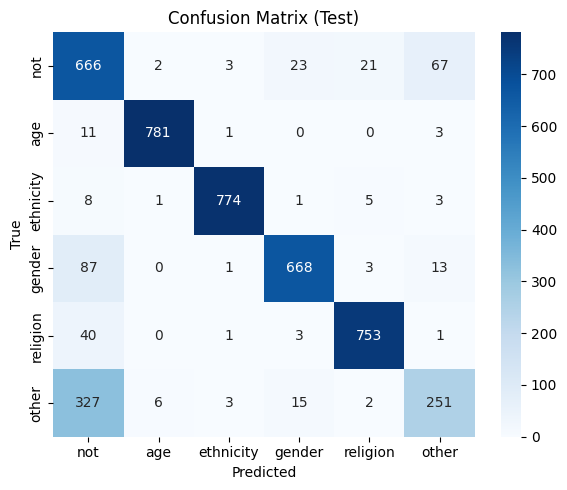

,label,precision,recall,f1,support
0,not,0.584723,0.851662,0.693389,782
1,age,0.988608,0.981156,0.984868,796
2,ethnicity,0.988506,0.977273,0.982857,792
3,gender,0.940845,0.865285,0.901484,772
4,religion,0.960459,0.943609,0.951960,798
5,other,0.742604,0.415563,0.532909,604


In [19]:
# %% [code]
test_metrics = evaluate(model, test_dl, threshold=BIN_THRESHOLD)
print(json.dumps({k:v for k,v in test_metrics.items() if k not in ["confusion_matrix","y_true_6","y_pred_6","p_binary"]}, indent=2))

# Confusion matrix
labels6 = ["not","age","ethnicity","gender","religion","other"]
cm = np.array(test_metrics["confusion_matrix"])
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels6, yticklabels=labels6, ax=ax)
ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title("Confusion Matrix (Test)")
plt.tight_layout(); plt.show()

# Per-class F1
from sklearn.metrics import precision_recall_fscore_support
y_true = np.array(test_metrics["y_true_6"])
y_pred = np.array(test_metrics["y_pred_6"])
prec, rec, f1, sup = precision_recall_fscore_support(y_true, y_pred, labels=[0,1,2,3,4,5], zero_division=0)
per_class = pd.DataFrame({"label":labels6, "precision":prec, "recall":rec, "f1":f1, "support":sup})
display(per_class)


## Save tokenizer, config, label mapping, metrics

In [20]:
# %% [code]
# Save tokenizer
tokenizer.save_pretrained(ARTIFACTS_DIR)

# Save config + label map + thresholds + metrics
config = {
    "encoder": ENCODER,
    "max_len": MAX_LEN,
    "bin_threshold": BIN_THRESHOLD,
    "lambda_loss": LAMBDA,
}
with open(os.path.join(ARTIFACTS_DIR, "config.json"), "w") as f:
    json.dump(config, f, indent=2)

with open(os.path.join(ARTIFACTS_DIR, "label_mapping.json"), "w") as f:
    json.dump({"0":"not_cyberbullying", "1":"age", "2":"ethnicity", "3":"gender", "4":"religion", "5":"other"}, f, indent=2)

# metrics.json
save_metrics = {k:v for k,v in test_metrics.items() if k!="p_binary"}
with open(os.path.join(ARTIFACTS_DIR, "metrics.json"), "w") as f:
    json.dump(save_metrics, f, indent=2)

print("Saved artifacts:", os.listdir(ARTIFACTS_DIR))


Saved artifacts: ['config.json', 'label_mapping.json', 'merges.txt', 'metrics.json', 'model_state_dict.pt', 'special_tokens_map.json', 'tokenizer.json', 'tokenizer_config.json', 'vocab.json']


## Simple inference helper

In [31]:
# %% [code]
@torch.no_grad()
def predict_one(text: str, threshold=BIN_THRESHOLD):
    enc = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=MAX_LEN).to(device)
    logit_bin, logits_multi = model(**enc)
    p_b = torch.sigmoid(logit_bin).item()
    if p_b < threshold:
        return {"binary":"not_cyberbullying", "p_bully":p_b, "type":None, "probs":None}
    probs = torch.softmax(logits_multi, dim=-1).squeeze(0).cpu().numpy().tolist()
    idx = int(np.argmax(probs))
    labels5 = ["age","ethnicity","gender","religion","other"]
    return {"binary":"bullying", "p_bully":p_b, "type":labels5[idx], "probs":{l:round(p,3) for l,p in zip(labels5,probs)}}

print(predict_one("What wuld happen to Kat and Andre if Manu and Pete turned around and said double elimination?Kat's head would explode! #mkr @mykitchenrules"))


{'binary': 'not_cyberbullying', 'p_bully': 0.04844193533062935, 'type': None, 'probs': None}
